# Testing Negativ Binomail and Gamma loss Data fitting and parameter estimation within PyGOM

This is an example of parameter fitting with an SIR model.

In [1]:
from pygom import Transition, TransitionType, SimulateOde, SquareLoss, PoissonLoss, NormalLoss, NegBinomLoss, GammaLoss
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
import copy

from scipy.optimize import minimize

In [2]:
# Generate some data for fitting

# Standard SIR model with 2 parameters
# construct model 
states = ['S', 'I', 'R']
params = ['beta', 'gamma', 'N']
transitions = [Transition(origin='S', destination='I', equation='beta*S*I/N', 
                          transition_type=TransitionType.T),
               Transition(origin='I', destination='R', equation='gamma*I', 
                          transition_type=TransitionType.T)]
model = SimulateOde(states, params, transition=transitions)

In [3]:
# initial conditions 
N = 1e6
in_inf = 2
init_state = [N - in_inf, in_inf, 0.0]
# time 
t = np.arange (0 , 51 , 0.25)
# deterministic parameter values
param_evals = [('beta', 3.6), ('gamma', 0.2), ('N', N)]
model.parameters = param_evals
model.initial_values = (init_state, t[0])

In [4]:
# run 1 simulations
data = model.integrate(t[1:])

Data over 100 days, with observations from every day for infected and removed populations.

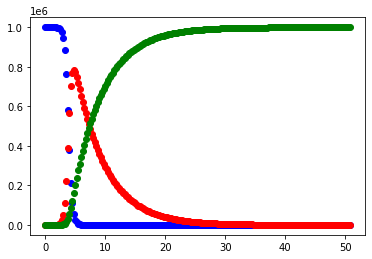

In [5]:
plt.plot(t,data[:,0], 'bo') # infected observations
plt.plot(t,data[:,1], 'ro') # infected observations
plt.plot(t,data[:,2], 'go') # removed observations (recoverd/died)

plt.show()

# Adding random noise to produce Continuos Data

Our data needs to be have some noise so lets put it through a function for randomisation using the gamma distribution.

In [6]:
def runif_noise(x,noise_prop):
    '''
    Takes x and adds noise on the uniform distribution.
    '''
    i_len,j_len = x.shape
    ans = copy.deepcopy(x)
    for i in range(i_len):
        for j in range(j_len):
            ans[i,j]=x[i,j] + x[i,j]*np.random.uniform(low=-noise_prop,high=noise_prop,size=1)
                   
    return ans

In [7]:
data[0,:]

array([9.99998e+05, 2.00000e+00, 0.00000e+00])

In [8]:
noised_data = runif_noise(data,1/3)
#we stil want the first row from data
noised_data[0,:] = data[0,:]
(noised_data-data)/data

<ipython-input-8-74bf619963ac>:4: RuntimeWarning: invalid value encountered in true_divide
  (noised_data-data)/data


array([[ 0.        ,  0.        ,         nan],
       [-0.26594371,  0.0481614 ,  0.14354852],
       [ 0.18044689, -0.21459589, -0.23607263],
       [-0.22631835, -0.25986512,  0.00977265],
       [ 0.08317535, -0.24033984, -0.13717155],
       [ 0.01893378, -0.30765339, -0.20936384],
       [-0.1927195 , -0.20495292,  0.14883087],
       [-0.31513136,  0.29092017,  0.20333613],
       [-0.0144959 , -0.15434097,  0.15017585],
       [-0.06943103, -0.04553612,  0.24527238],
       [ 0.1423363 , -0.26289285, -0.27731679],
       [ 0.22902387, -0.11970823, -0.0786823 ],
       [ 0.24507763,  0.13939913,  0.19873885],
       [ 0.0851626 ,  0.33156697, -0.02946794],
       [-0.18589297,  0.28048003,  0.15186529],
       [ 0.10976604, -0.27140908, -0.29451267],
       [-0.02481169, -0.01567338,  0.12217416],
       [-0.00554871, -0.31163176,  0.09909475],
       [ 0.20449806, -0.13271217, -0.21380146],
       [ 0.23288222, -0.26931907,  0.17116807],
       [-0.16775002, -0.08171666,  0.328

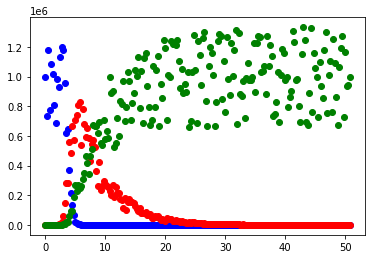

In [9]:
plt.plot(t,noised_data[:,0], 'bo') # infected observations
plt.plot(t,noised_data[:,1], 'ro') # infected observations
plt.plot(t,noised_data[:,2], 'go') # removed observations (recoverd/died)

plt.show()

We provide a guess for $\beta$ and $\gamma$. 

This example assumes we have information about the infected and removed population, up to 50 days of the epidemic.


In [10]:
data_to_fit = noised_data[:,1:3]
data_to_fit = data_to_fit[1::,:]
data_to_fit

array([[4.90464096e+00, 1.80229297e-01],
       [8.59843745e+00, 4.02088747e-01],
       [1.89574734e+01, 1.40262775e+00],
       [4.55221314e+01, 2.94002911e+00],
       [9.70595088e+01, 6.42741549e+00],
       [2.60715165e+02, 2.20294695e+01],
       [9.89941096e+02, 5.41627913e+01],
       [1.51549915e+03, 1.21234960e+02],
       [3.99119374e+03, 3.06882053e+02],
       [7.16646079e+03, 4.15491759e+02],
       [1.97356855e+04, 1.23045676e+03],
       [5.78166023e+04, 3.68388673e+03],
       [1.46862042e+05, 6.72234947e+03],
       [2.83221926e+05, 1.72384073e+04],
       [2.82099064e+05, 2.11595297e+04],
       [5.58399812e+05, 6.05232963e+04],
       [4.82619234e+05, 9.44362098e+04],
       [6.65765758e+05, 9.66241419e+04],
       [5.72747123e+05, 1.89549046e+05],
       [7.09146912e+05, 2.66809758e+05],
       [7.40234990e+05, 2.31329292e+05],
       [8.09839926e+05, 2.66144343e+05],
       [8.28408036e+05, 2.49165951e+05],
       [5.35922195e+05, 2.62582973e+05],
       [7.802208

## Fitting Normal loss

In [11]:
param_evals

[('beta', 3.6), ('gamma', 0.2), ('N', 1000000.0)]

In [12]:
# Initial guess of parameters, and bounding constraints
theta = [3, 0.15,1e6]
boxBounds = [(2,5),(0.0,1.0),(1e6,1e6)]

objSIR = NormalLoss(theta, model, x0=data[0,:], t0=t[0], t=t[1::], y=data_to_fit, state_name=['I','R'])

In [13]:
objSIR.cost()

4209072260954.626

In [14]:
# perform optimization
res = minimize(fun=objSIR.cost,
                jac=objSIR.sensitivity,
                x0=theta,
                bounds=boxBounds,
                method='BFGS')
print(res)

C:\Users\martin.grunnill\AppData\Local\Continuum\anaconda3\envs\pygom_loss_20200410\lib\site-packages\scipy\optimize\_minimize.py:521: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


      fun: 3149715468391.5137
 hess_inv: array([[ 1.02285673e-11, -3.28483610e-14,  3.23263121e-06],
       [-3.28483423e-14,  5.00246087e-15, -3.92052034e-09],
       [ 3.23263111e-06, -3.92052576e-09,  1.06428103e+00]])
      jac: array([-1.89198473e+03,  2.05662437e+05,  6.51297284e-03])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 74
      nit: 10
     njev: 62
   status: 2
  success: False
        x: array([3.84976144e+00, 2.02859211e-01, 1.11835931e+06])


In [15]:
# perform optimization
res = minimize(fun=objSIR.cost,
                jac=objSIR.sensitivity,
                x0=theta,
                bounds=boxBounds,
                method='L-BFGS-B')
print(res)

      fun: 3149715468391.6045
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.80002429e+03,  1.18458645e+05, -9.63846812e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 12
      nit: 9
   status: 0
  success: True
        x: array([3.44232967e+00, 2.02859211e-01, 1.00000000e+06])


In [16]:
display(theta,boxBounds,param_evals)

[3, 0.15, 1000000.0]

[(2, 5), (0.0, 1.0), (1000000.0, 1000000.0)]

[('beta', 3.6), ('gamma', 0.2), ('N', 1000000.0)]

## Fitting Gamma loss

In [17]:
# Initial guess of parameters, and bounding constraints
objSIR = GammaLoss(theta, model, x0=data[0,:], t0=t[0], t=t[1::], y=data_to_fit, state_name=['I','R'])

In [18]:
objSIR.sensitivity()

array([-1.17798986e+03, -1.40835509e+04,  3.53396958e-03])

In [19]:
objSIR.cost()

5065.797364214306

In [20]:
# perform optimization
res = minimize(fun=objSIR.cost,
                jac=objSIR.sensitivity,
                x0=theta,
                bounds=boxBounds,
                method='BFGS')
print(res)

C:\Users\martin.grunnill\AppData\Local\Continuum\anaconda3\envs\pygom_loss_20200410\lib\site-packages\scipy\optimize\_minimize.py:521: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


      fun: 4716.804547726841
 hess_inv: array([[ 1.93830562e-03, -1.55181618e-05,  1.36514445e-06],
       [-1.55181618e-05,  1.96280251e-06,  1.90886878e-08],
       [ 1.36514445e-06,  1.90886878e-08,  1.00000000e+00]])
      jac: array([ 8.67860428e-08, -3.11402124e-06, -3.11981179e-13])
  message: 'Optimization terminated successfully.'
     nfev: 15
      nit: 10
     njev: 15
   status: 0
  success: True
        x: array([3.59483138e+00, 1.99847237e-01, 1.00000000e+06])


In [21]:
# perform optimization
res = minimize(fun=objSIR.cost,
                jac=objSIR.sensitivity,
                x0=theta,
                bounds=boxBounds,
                method='L-BFGS-B')
print(res)

C:\Users\martin.grunnill\AppData\Local\Continuum\anaconda3\envs\pygom_loss_20200410\lib\site-packages\pygom-0.1.7.dev1+gbbd58f3.d20200410-py3.8-win-amd64.egg\pygom\utilR\distn.py:108: RuntimeWarning: invalid value encountered in log
  logpdf_p3= -shape*np.log(mu/shape)


      fun: 4716.804547726802
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9.16923207e-05, -1.70890676e-03,  3.29618418e-10])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 15
      nit: 10
   status: 0
  success: True
        x: array([3.59483123e+00, 1.99847235e-01, 1.00000000e+06])


In [22]:
display(theta,boxBounds,param_evals)

[3, 0.15, 1000000.0]

[(2, 5), (0.0, 1.0), (1000000.0, 1000000.0)]

[('beta', 3.6), ('gamma', 0.2), ('N', 1000000.0)]

# Adding random noise to produce Count Data

Our data needs to a be counts:

In [23]:
int_data_to_fit = np.around(data_to_fit)
int_data_to_fit 

array([[5.000000e+00, 0.000000e+00],
       [9.000000e+00, 0.000000e+00],
       [1.900000e+01, 1.000000e+00],
       [4.600000e+01, 3.000000e+00],
       [9.700000e+01, 6.000000e+00],
       [2.610000e+02, 2.200000e+01],
       [9.900000e+02, 5.400000e+01],
       [1.515000e+03, 1.210000e+02],
       [3.991000e+03, 3.070000e+02],
       [7.166000e+03, 4.150000e+02],
       [1.973600e+04, 1.230000e+03],
       [5.781700e+04, 3.684000e+03],
       [1.468620e+05, 6.722000e+03],
       [2.832220e+05, 1.723800e+04],
       [2.820990e+05, 2.116000e+04],
       [5.584000e+05, 6.052300e+04],
       [4.826190e+05, 9.443600e+04],
       [6.657660e+05, 9.662400e+04],
       [5.727470e+05, 1.895490e+05],
       [7.091470e+05, 2.668100e+05],
       [7.402350e+05, 2.313290e+05],
       [8.098400e+05, 2.661440e+05],
       [8.284080e+05, 2.491660e+05],
       [5.359220e+05, 2.625830e+05],
       [7.802210e+05, 3.088350e+05],
       [6.826180e+05, 3.476890e+05],
       [5.921870e+05, 4.633670e+05],
 

## Poisson loss

In [24]:
# Initial guess of parameters, and bounding constraints
objSIR = PoissonLoss(theta, model, x0=data[0,:], t0=t[0], t=t[1::], y=int_data_to_fit, state_name=['I','R'])

In [25]:
objSIR.cost()

8329023.1484972015

In [26]:
# perform optimization
res = minimize(fun=objSIR.cost,
                jac=objSIR.sensitivity,
                x0=theta,
                bounds=boxBounds,
                method='BFGS')
print(res)

      fun: 3557908.6464113127
 hess_inv: array([[ 1.27472646e-07, -3.23818317e-09,  2.26214178e-06],
       [-3.23818317e-09,  9.56376557e-10,  2.13419691e-08],
       [ 2.26214178e-06,  2.13419691e-08,  1.00001208e+00]])
      jac: array([-6.34498993e-04,  1.86534335e-03,  2.25490671e-09])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 109
      nit: 11
     njev: 97
   status: 2
  success: False
        x: array([3.55378376e+00, 1.99169650e-01, 1.00000147e+06])


In [27]:
# perform optimization
res = minimize(fun=objSIR.cost,
                jac=objSIR.sensitivity,
                x0=theta,
                bounds=boxBounds,
                method='L-BFGS-B')
print(res)

      fun: 3557908.646411574
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.83986623e-01, -4.04398552e-01,  1.00922556e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 15
      nit: 11
   status: 0
  success: True
        x: array([3.55377851e+00, 1.99169650e-01, 1.00000000e+06])


In [28]:
display(theta,boxBounds,param_evals)

[3, 0.15, 1000000.0]

[(2, 5), (0.0, 1.0), (1000000.0, 1000000.0)]

[('beta', 3.6), ('gamma', 0.2), ('N', 1000000.0)]

## NegBinom loss

In [29]:
# Initial guess of parameters, and bounding constraints
objSIR = NegBinomLoss(theta, model, x0=data[0,:], t0=t[0], t=t[1::], y=int_data_to_fit, state_name=['I','R'])

C:\Users\martin.grunnill\AppData\Local\Continuum\anaconda3\envs\pygom_loss_20200410\lib\site-packages\pygom-0.1.7.dev1+gbbd58f3.d20200410-py3.8-win-amd64.egg\pygom\utilR\distn.py:450: RuntimeWarning: divide by zero encountered in log
  logpmf_p4= x*(np.log(mu) - np.log(k + mu))
C:\Users\martin.grunnill\AppData\Local\Continuum\anaconda3\envs\pygom_loss_20200410\lib\site-packages\pygom-0.1.7.dev1+gbbd58f3.d20200410-py3.8-win-amd64.egg\pygom\utilR\distn.py:450: RuntimeWarning: invalid value encountered in multiply
  logpmf_p4= x*(np.log(mu) - np.log(k + mu))


In [30]:
objSIR.sensitivity()

array([-2.92555910e+02, -3.50195352e+03,  8.77667731e-04])

In [31]:
objSIR.cost()

5041.425763395273

In [32]:
# perform optimization
res = minimize(fun=objSIR.cost,
                jac=objSIR.sensitivity,
                x0=theta,
                bounds=boxBounds,
                method='BFGS')
print(res)

C:\Users\martin.grunnill\AppData\Local\Continuum\anaconda3\envs\pygom_loss_20200410\lib\site-packages\scipy\optimize\_minimize.py:521: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


      fun: 4867.899797539529
 hess_inv: array([[ 7.67776936e-03, -5.97617430e-05,  1.74660277e-06],
       [-5.97617430e-05,  7.85112146e-06,  1.25323010e-08],
       [ 1.74660277e-06,  1.25323010e-08,  1.00000000e+00]])
      jac: array([ 8.13167572e-09, -3.92696007e-06, -2.92247481e-14])
  message: 'Optimization terminated successfully.'
     nfev: 15
      nit: 10
     njev: 15
   status: 0
  success: True
        x: array([3.59393939e+00, 1.99830691e-01, 1.00000000e+06])


In [33]:
# perform optimization
res = minimize(fun=objSIR.cost,
                jac=objSIR.sensitivity,
                x0=theta,
                bounds=boxBounds,
                method='L-BFGS-B')
print(res)

C:\Users\martin.grunnill\AppData\Local\Continuum\anaconda3\envs\pygom_loss_20200410\lib\site-packages\pygom-0.1.7.dev1+gbbd58f3.d20200410-py3.8-win-amd64.egg\pygom\utilR\distn.py:450: RuntimeWarning: invalid value encountered in log
  logpmf_p4= x*(np.log(mu) - np.log(k + mu))


      fun: 4867.899797547801
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.12746856e-04,  1.84890228e-02, -1.48338804e-09])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 17
      nit: 12
   status: 0
  success: True
        x: array([3.59394146e+00, 1.99830811e-01, 1.00000000e+06])


In [34]:
display(theta,boxBounds,param_evals)

[3, 0.15, 1000000.0]

[(2, 5), (0.0, 1.0), (1000000.0, 1000000.0)]

[('beta', 3.6), ('gamma', 0.2), ('N', 1000000.0)]